# Jax Implementation of MPM for Axial vibration of 1D bar

## Analytical Solution

In [29]:
import numpy as np

def axial_vibration_bar1d(L, E, rho, duration, dt, v0, x):

    # Frequency of system mode 1
    w1 = np.pi / (2 * L) * np.sqrt(E/rho)
    b1 = np.pi / (2 * L)

    # position and velocity in time
    tt, vt, xt = [], [], []

    nsteps = int(duration/dt)
    t = 0
    for _ in range(nsteps):
        vt.append(v0 * np.cos(w1 * t) * np.sin(b1 * x))
        xt.append(v0 / w1 * np.sin(w1 * t) * np.sin(b1 * x))
        tt.append(t)

        t += dt
    
    return tt, vt, xt

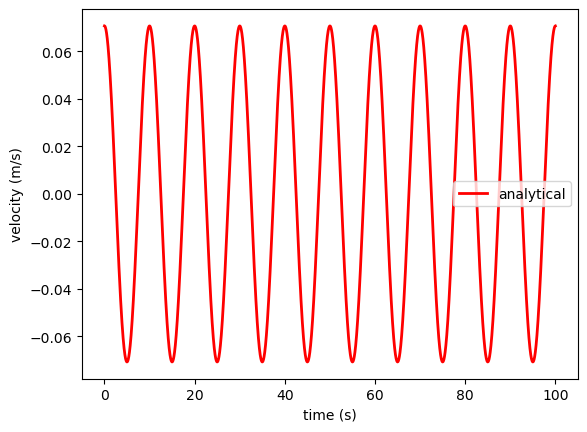

In [30]:
import matplotlib.pyplot as plt

# Properties
E = 100
L = 25

# analytical solution at the end of the bar
ta, va, xa = axial_vibration_bar1d(L = L, E = E, rho = 1, duration = 100, dt = 0.01, v0 = 0.1, x = 12.5)

plt.plot(ta, va, 'r',linewidth=2,label='analytical')

plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()

## Jax MPM Implementation

In [26]:
import jax.numpy as jnp

# mass tolerance
tol = 1e-6

# Domain
L = 25

# Material properties
E = 100
rho = 1

# Computational grid

nelements = 13 # number of elements
dx = L / nelements # element length

# Create equally spaced nodes
x_n = jnp.linspace(0, L, nelements+1)
nnodes = len(x_n)

# Set-up a 2D array of elements with node ids
elements = jnp.zeros((nelements, 2), dtype = int)
for nid in range(nelements):
    elements = elements.at[nid, :].set(jnp.array([nid, nid+1]))
    
# Loading conditions
v0 = 0.1             # initial velocity
c  = jnp.sqrt(E/rho)  # speed of sound
b1 = jnp.pi / (2 * L) # beta1
w1 = b1 * c          # omega1

# Create material points at the center of each element
nparticles = nelements  # number of particles
# Id of the particle in the central element
pmid = int(jnp.floor((nparticles/2)))

# Material point properties
x_p      = jnp.zeros(nparticles)       # positions
vol_p    = jnp.ones(nparticles) * dx   # volume
mass_p   = vol_p * rho                # mass
stress_p = jnp.zeros(nparticles)       # stress
vel_p    = jnp.zeros(nparticles)       # velocity
vol0_p   = vol_p                      # initial volume

for i in range(nelements):
    # Create particle at the center
    x_p = x_p.at[i].set(0.5 * (x_n[i] + x_n[i+1]))
    # set initial velocities
    vel_p = vel_p.at[i].set(v0 * jnp.sin(b1 * x_p[i]))

# Time steps and duration
duration = 100
dt_crit = dx / c
dt = 0.1 * dt_crit
t = 0
nsteps = int(duration / dt)

tt, vt, xt = [], [], []

for step in range(nsteps):
    # reset nodal values
    mass_n  = jnp.zeros(nnodes)  # mass
    mom_n   = jnp.zeros(nnodes)  # momentum
    fint_n = jnp.zeros(nnodes)  # internal force

    # iterate through each element
    for id in range(nelements):
        # get nodal ids
        nid1, nid2 = elements[id]
        
        # compute shape functions and derivatives
        N1 = 1 - abs(x_p[id] - x_n[nid1]) / dx
        N2 = 1 - abs(x_p[id] - x_n[nid2]) / dx
        dN1 = -1/dx
        dN2 = 1/dx

        # map particle mass and momentum to nodes
        mass_n = mass_n.at[nid1].set(mass_n[nid1] + N1 * mass_p[id])
        mass_n = mass_n.at[nid2].set(mass_n[nid2] + N2 * mass_p[id])
        mom_n = mom_n.at[nid1].set(mom_n[nid1] + N1 * mass_p[id] * vel_p[id])
        mom_n = mom_n.at[nid2].set(mom_n[nid2] + N2 * mass_p[id] * vel_p[id])
        
        # compute nodal internal force
        fint_n = fint_n.at[nid1].set(fint_n[nid1] - vol_p[id] * stress_p[id] * dN1)
        fint_n = fint_n.at[nid2].set(fint_n[nid2] - vol_p[id] * stress_p[id] * dN2)

    # apply boundary conditions
    mom_n = mom_n.at[0].set(0)  # Nodal velocity v = 0 in m * v at node 0.
    fint_n = fint_n.at[0].set(0)  # Nodal force f = m * a, where a = 0 at node 0.

    # update nodal momentum
    mom_n = mom_n + fint_n * dt

    # update particle velocity position and stress
    # iterate through each element
    for id in range(nelements):
        # get nodal ids
        nid1, nid2 = elements[id]
        
        # compute shape functions and derivatives
        N1 = 1 - abs(x_p[id] - x_n[nid1]) / dx
        N2 = 1 - abs(x_p[id] - x_n[nid2]) / dx
        dN1 = -1/dx
        dN2 = 1/dx

        # compute particle velocity
        if (mass_n[nid1]) > tol:
            vel_p = vel_p.at[id].set(vel_p[id] + dt * N1 * fint_n[nid1] / mass_n[nid1])
        if (mass_n[nid2]) > tol:
            vel_p = vel_p.at[id].set(vel_p[id] + dt * N2 * fint_n[nid2] / mass_n[nid2])
        
        # update particle position based on nodal momentum
        x_p = x_p.at[id].set(x_p[id] + dt * (N1 * mom_n[nid1]/mass_n[nid1] + N2 * mom_n[nid2]/mass_n[nid2]))

        # nodal velocity
        nv1 = mom_n[nid1]/mass_n[nid1]
        nv2 = mom_n[nid2]/mass_n[nid2]

        # Apply boundary condition
        # Rendundant, since momentum and forces are already set to zero
        # if (nid1 == 0): nv1 = 0

        # rate of strain increment
        grad_v = dN1 * nv1 + dN2 * nv2
        # particle dstrain
        dstrain = grad_v * dt
        # particle volume
        vol_p = vol_p.at[id].set((1 + dstrain) * vol_p[id])        
        # update stress using linear elastic model
        stress_p = stress_p.at[id].set(stress_p[id] + E * dstrain)

    # update plot params
    tt.append(t)
    vt.append(vel_p[pmid])
    xt.append(x_p[pmid])

    t = t + dt

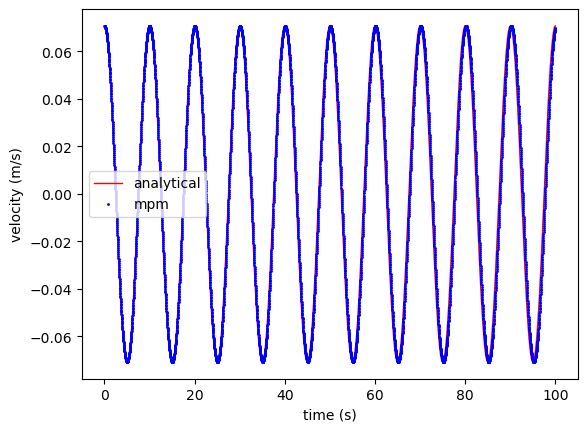

In [31]:
import matplotlib.pyplot as plt

plt.plot(ta, va, 'r', linewidth=1,label='analytical')
plt.plot(tt, vt, 'ob', markersize=1, label='mpm')

plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()